In [ ]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

import string
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("hazemfahmy/openned-closed-eyes")
print("Dataset Path:", path)

Dataset Path: /root/.cache/kagglehub/datasets/hazemfahmy/openned-closed-eyes/versions/6


In [ ]:
path = "/content/splitted_Data/train"

Closed_eye_dir = os.path.join(path, "Closed")
Opened_eye_dir = os.path.join(path, "Opened")

Closed_eye = os.listdir(Closed_eye_dir)
Opened_eye = os.listdir(Opened_eye_dir)

X = []
Y = []

for i, image_name in enumerate(Opened_eye):
    image_path = os.path.join(Opened_eye_dir, image_name)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw, channels=3)
    image_resized = tf.image.resize(image, [64, 64])
    X.append(image_resized.numpy())
    Y.append(0)

for i, image_name in enumerate(Closed_eye):
    image_path = os.path.join(Closed_eye_dir, image_name)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw, channels=3)
    image_resized = tf.image.resize(image, [64, 64])
    X.append(image_resized.numpy())
    Y.append(1)

X = np.array(X)
Y = np.array(Y)
print("Data Shape after resizing:", X.shape)

Data Shape after resizing: (1363, 64, 64, 3)


In [ ]:
# Define the processing function
def process_images(image_list, image_dir, target_size=(64, 64), apply_histogram_equalization=False):
    processed_images = []
    for image_name in image_list:
        # Full path to the image
        image_path = os.path.join(image_dir, image_name)
        # Load and decode image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw, channels=3)
        image_resized = tf.image.resize(image, target_size).numpy().astype(np.uint8)

        # Convert to grayscale
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        if apply_histogram_equalization:
            # Apply histogram equalization
            image_gray = cv2.equalizeHist(image_gray)
        processed_images.append(image_gray)

    # Convert to numpy array
    processed_images = np.array(processed_images)
    print(f"Shape after processing: {processed_images.shape}")
    return processed_images

# Process datasets
print("Processing Opened Eyes...")
X_opened = process_images(Opened_eye, Opened_eye_dir, apply_histogram_equalization=True)

print("Processing Closed Eyes...")
X_closed = process_images(Closed_eye, Closed_eye_dir, apply_histogram_equalization=True)

# Combine datasets
X = np.vstack([X_opened, X_closed])
Y = np.array([0] * len(Opened_eye) + [1] * len(Closed_eye))

# Print final dataset shapes
print("Final Dataset Shapes:")
print(f"X shape: {X.shape}")  # Shape of processed images
print(f"Y shape: {Y.shape}")  # Shape of labels

Processing Opened Eyes...
Shape after processing: (659, 64, 64)
Processing Closed Eyes...
Shape after processing: (704, 64, 64)
Final Dataset Shapes:
X shape: (1363, 64, 64)
Y shape: (1363,)


In [ ]:
#Normalization
X = np.clip(X, 0, 255)
X = X / 255.0
print("Min value :", X.min())
print("Max value :", X.max())

Min value : 0.0
Max value : 1.0


In [ ]:
# Function to apply data augmentation
def augment_image(image):
    # Reshape the image to add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.random_flip_left_right(image)  # Flip horizontally
    image = tf.image.random_flip_up_down(image)    # Flip vertically
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    # Ensure random_crop receives a 3D image
    image = tf.image.random_crop(image, size=[48, 48, 1])  # Random crop
    image = tf.image.resize(image, [64, 64])  # Resize back to 64x64
    # Squeeze to remove the channel dimension after augmentation if needed
    image = tf.squeeze(image, axis=-1)
    return image

# Load and augment data
augmented_X = []
augmented_Y = []

for i, (image, label) in enumerate(zip(X, Y)):
    # Convert image to Tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    # Apply augmentation
    augmented_image = augment_image(image_tensor)
    # Append augmented image and label to the new dataset
    augmented_X.append(augmented_image.numpy())
    augmented_Y.append(label)

# Combine original and augmented data
X_augmented = np.array(augmented_X + X.tolist())
Y_augmented = np.array(augmented_Y + Y.tolist())

print("Augmented Data Shape:", X_augmented.shape)
print("Augmented Labels Shape:", Y_augmented.shape)

Augmented Data Shape: (2726, 64, 64)
Augmented Labels Shape: (2726,)


In [ ]:
# Define the processing function
def process_images(image_list, image_dir, target_size=(64, 64), apply_histogram_equalization=False):
    processed_images = []
    for image_name in image_list:
        # Full path to the image
        image_path = os.path.join(image_dir, image_name)
        # Load and decode image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw, channels=3)
        image_resized = tf.image.resize(image, target_size).numpy().astype(np.uint8)

        # Convert to grayscale
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        if apply_histogram_equalization:
            # Apply histogram equalization
            image_gray = cv2.equalizeHist(image_gray)

        # Add processed image to the list
        processed_images.append(image_gray)

    # Convert to numpy array
    processed_images = np.array(processed_images)
    print(f"Shape after processing: {processed_images.shape}")
    return processed_images

# Process datasets
print("Processing Opened Eyes...")
X_opened = process_images(Opened_eye, Opened_eye_dir, apply_histogram_equalization=True)

print("Processing Closed Eyes...")
X_closed = process_images(Closed_eye, Closed_eye_dir, apply_histogram_equalization=True)

# Combine datasets
X = np.vstack([X_opened, X_closed])
Y = np.array([0] * len(Opened_eye) + [1] * len(Closed_eye))

# Print final dataset shapes
print("Final Dataset Shapes:")
print(f"X shape: {X.shape}")  # Shape of processed images
print(f"Y shape: {Y.shape}")  # Shape of labels

Processing Opened Eyes...
Shape after processing: (659, 64, 64)
Processing Closed Eyes...
Shape after processing: (704, 64, 64)
Final Dataset Shapes:
X shape: (1363, 64, 64)
Y shape: (1363,)


In [ ]:
# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
x_train , x_temp ,y_train ,y_temp = train_test_split(X,Y,test_size=.4,shuffle=True,random_state=42)
x_test, x_val ,y_test , y_val = train_test_split(x_temp,y_temp,test_size=0.5,shuffle=True , random_state=42)

print(f'Train set: {x_train.shape}, {y_train.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Train set: (817, 64, 64), (817,)
Validation set: (273, 64, 64), (273,)
Test set: (273, 64, 64), (273,)


In [ ]:
# Assuming X and y are already defined
# Add channel dimension to make it (num_samples, 64, 64, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Verify shapes
print(x_train.shape)  # Should be (1022, 64, 64, 1)
print(x_val.shape)    # Should be (341, 64, 64, 1)
print(x_test.shape)   # Should be (341, 64, 64, 1)
print(y_train.shape)  # Should be (1022, 4)
print(y_val.shape)    # Should be (341, 4)
print(y_test.shape)   # Should be (341, 4)

(817, 64, 64, 1)
(273, 64, 64, 1)
(273, 64, 64, 1)
(817, 4)
(273, 4)
(273, 4)


In [ ]:
# Define ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator()

# Convert numpy arrays to batches
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(x_test, y_test, batch_size=32)

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.4568 - loss: 28.4283 - val_accuracy: 0.5897 - val_loss: 0.7144
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.5166 - loss: 0.7364 - val_accuracy: 0.4872 - val_loss: 0.7079
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.5648 - loss: 0.7024 - val_accuracy: 0.5275 - val_loss: 0.7009
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.5497 - loss: 0.6966 - val_accuracy: 0.5861 - val_loss: 0.6727
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.5388 - loss: 0.6897 - val_accuracy: 0.5458 - val_loss: 0.6877
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.5820 - loss: 0.6780 - val_accuracy: 0.6227 - val_loss: 0.6567
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.6493 - loss: 0.6345 - val_accuracy: 0.5788 - val_loss: 0.7085
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.6988 - loss: 0.6003 - val_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

model.save("/content/drive/MyDrive/drowsiness_model_checkpoints_s/best_model.h5")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9073 - loss: 0.4081


Test Loss: 0.4120962619781494
Test Accuracy: 0.901098906993866


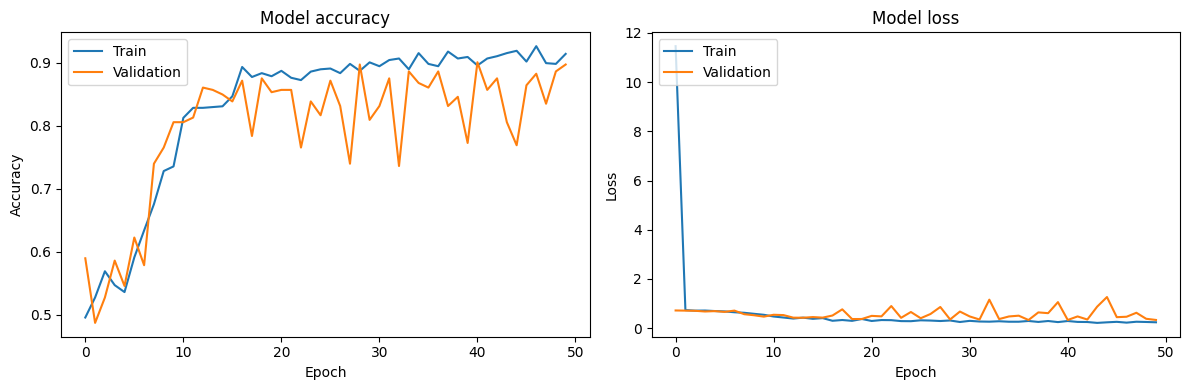

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# `model` is trained TensorFlow model and `X_train` is training data
import random

random_indices = random.sample(range(len(x_train)), 6)

# Create a dataset from selected indices
def load_random_samples(X, indices):
    selected_images = [X[idx] for idx in indices]
    return np.array(selected_images)

random_samples = load_random_samples(x_train, random_indices)

# Predictions
predictions = model.predict(random_samples)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming `y_train` contains the actual labels
actual_labels = [y_train[idx] for idx in random_indices]
actual_classes = np.argmax(actual_labels, axis=1)

# Predictions
predictions = model.predict(random_samples)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming `y_train` contains the actual labels
actual_labels = [y_train[idx] for idx in random_indices]
actual_classes = np.argmax(actual_labels, axis=1)


fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axs = axes.ravel()

for i in range(6):
    img = random_samples[i].squeeze()  # Squeeze to remove single-dimensional entries
    prediction = predicted_classes[i]
    actual_label = actual_classes[i]

    axs[i].imshow(img, cmap='gray')  # Use 'gray' cmap for grayscale images
    col = 'green' if actual_label == prediction else 'red'
    axs[i].set_title(f'Predicted: {prediction}\nActual: {actual_label}', color=col)
    axs[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [ ]:
!pip uninstall mediapipe
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/drowsiness_model_checkpoints_s/best_model.h5")


Processing Frame 1...
Left Eye: (flipped)


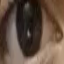

Right Eye:


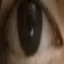

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Left Eye: 0.2652
Right Eye: 0.2651
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0013399124)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 2...
Left Eye: (flipped)


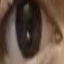

Right Eye:


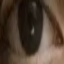

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Left Eye: 0.2653
Right Eye: 0.2650
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0012230873)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 3...
Left Eye: (flipped)


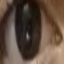

Right Eye:


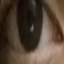

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Left Eye: 0.2653
Right Eye: 0.2652
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0022155046)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 4...
Left Eye: (flipped)


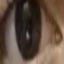

Right Eye:


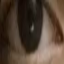

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Left Eye: 0.2652
Right Eye: 0.2651
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0016856194)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 5...
Left Eye: (flipped)


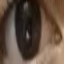

Right Eye:


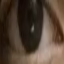

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Left Eye: 0.2653
Right Eye: 0.2651
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0012230873)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 6...
Left Eye: (flipped)


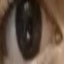

Right Eye:


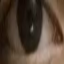

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Left Eye: 0.2652
Right Eye: 0.2651
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0017356873)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 7...
Left Eye: (flipped)


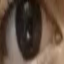

Right Eye:


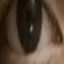

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Left Eye: 0.2652
Right Eye: 0.2652
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.002361536)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 8...
Left Eye: (flipped)


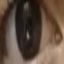

Right Eye:


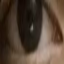

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Left Eye: 0.2653
Right Eye: 0.2652
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.002426505)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 9...
Left Eye: (flipped)


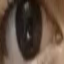

Right Eye:


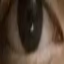

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Left Eye: 0.2653
Right Eye: 0.2651
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0019812584)}
→ Fuzzy Prediction: not_drowsy

Processing Frame 10...
Left Eye: (flipped)


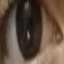

Right Eye:


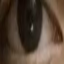

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Left Eye: 0.2653
Right Eye: 0.2652
Average: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.002449751)}
→ Fuzzy Prediction: not_drowsy
Overall Average for 10 frames: 0.2652
Memberships: {'drowsy': 0, 'not_drowsy': np.float32(0.0018644333)}
→ Final Fuzzy Prediction: not_drowsy


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_eye(eye_input):
    img = cv2.cvtColor(eye_input, cv2.COLOR_BGR2GRAY)         # Convert to grayscale
    img = img / 255.0                                   # Normalize
    img = np.expand_dims(img, axis=0)                   # Add batch dimension
    img = np.expand_dims(img, axis=-1)                  # Add channel dimension
    return img


def process_plot_img(left_input, right_input):
    # Preprocess both eyes
    left_eye_processed = preprocess_eye(left_input)
    right_eye_processed = preprocess_eye(right_input)

    # Check shapes
    print("Left eye shape:", left_eye_processed.shape)   # (1, 64, 64, 1)
    print("Right eye shape:", right_eye_processed.shape) # (1, 64, 64, 1)

    return left_eye_processed, right_eye_processed

def fuzzify(pred):
    # Drowsy: High membership for lower values
    drowsy = max(0, min(1, (0.265 - pred) / 0.05))  # Z-shape (approx)

    # Not Drowsy: High membership for higher values
    not_drowsy = max(0, min(1, (pred - 0.2651) / 0.05))  # S-shape (approx)

    return {
        'drowsy': drowsy,
        'not_drowsy': not_drowsy
    }


def predict_eye_state(model, eye_image, lower=0.2650):
    if eye_image is None or eye_image.size == 0:
      print("Error: Invalid eye image. Skipping prediction.")
      return np.nan, "invalid_image"  # Return NaN and a label to indicate invalid image

    img_array = eye_image
    # Predict
    prediction = model.predict(img_array)[0][0]

    # Interpret result
    if prediction <= lower:
        label = 'drowsy'
    else:
        label = 'not_drowsy'

    return prediction, label

def prediction_per_frame(model, left_input, right_input):
    left_pred, left_label = predict_eye_state(model, left_input)
    right_pred, right_label = predict_eye_state(model, right_input)

    avg_pred = (left_pred + right_pred) / 2

    # Fuzzify the average prediction
    memberships = fuzzify(avg_pred)

    # Decide final label based on max membership
    final_label = max(memberships, key=memberships.get)

    # Output
    print(f"Left Eye: {left_pred:.4f}")
    print(f"Right Eye: {right_pred:.4f}")
    print(f"Average: {avg_pred:.4f}")
    print("Memberships:", memberships)
    print(f"→ Fuzzy Prediction: {final_label}")


    return avg_pred, final_label


mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

video_path = "/content/video1.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
max_frames = 10
overall_avg_pred = 0

while cap.isOpened() and frame_count < max_frames:
    success, image = cap.read()
    if not success:
        break

    frame_count += 1
    print(f"\nProcessing Frame {frame_count}...")

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            left_eye_indices = [362, 385, 387, 263, 373, 380]
            right_eye_indices = [33, 160, 158, 133, 153, 144]

            def get_eye_crop(indices):
                points = [(int(face_landmarks.landmark[i].x * w), int(face_landmarks.landmark[i].y * h)) for i in indices]
                x_coords, y_coords = zip(*points)
                x_min, x_max = max(min(x_coords)-5, 0), min(max(x_coords)+5, w)
                y_min, y_max = max(min(y_coords)-5, 0), min(max(y_coords)+5, h)
                return image[y_min:y_max, x_min:x_max]

            left_eye_crop = get_eye_crop(left_eye_indices)
            right_eye_crop = get_eye_crop(right_eye_indices)

            left_eye_resized = cv2.resize(left_eye_crop, (64, 64))
            right_eye_resized = cv2.resize(right_eye_crop, (64, 64))

            left_eye_resized = cv2.flip(left_eye_resized, 1)

            # Show results
            print("Left Eye: (flipped)")
            cv2_imshow(left_eye_resized)
            print("Right Eye:")
            cv2_imshow(right_eye_resized)

            left_eye_processed, right_eye_processed = process_plot_img(left_eye_resized, right_eye_resized)

            avg_pred, final_label = prediction_per_frame(model, left_eye_processed, right_eye_processed)

            overall_avg_pred += avg_pred

            if frame_count == 10:
              overall_avg_pred /= 10

                  # Fuzzify the average prediction
              memberships = fuzzify(overall_avg_pred)

              # Decide final label based on max membership
              final_label = max(memberships, key=memberships.get)

              print(f"Overall Average for 10 frames: {overall_avg_pred:.4f}")
              print("Memberships:", memberships)
              print(f"→ Final Fuzzy Prediction: {final_label}")
    else:
        print("No face landmarks detected.")

cap.release()



Processing Frame 1...
Left Eye: (flipped)


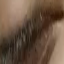

Right Eye:


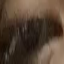

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Left Eye: 0.2651
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0013792515), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 2...
Left Eye: (flipped)


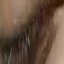

Right Eye:


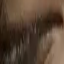

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Left Eye: 0.2650
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0016212463), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 3...
Left Eye: (flipped)


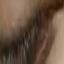

Right Eye:


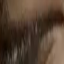

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Left Eye: 0.2650
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0018167496), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 4...
Left Eye: (flipped)


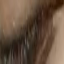

Right Eye:


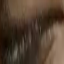

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Left Eye: 0.2650
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0013923645), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 5...
Left Eye: (flipped)


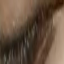

Right Eye:


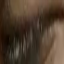

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Left Eye: 0.2650
Right Eye: 0.2649
Average: 0.2650
Memberships: {'drowsy': np.float32(0.0007355213), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 6...
Left Eye: (flipped)


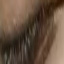

Right Eye:


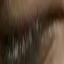

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Left Eye: 0.2651
Right Eye: 0.2648
Average: 0.2650
Memberships: {'drowsy': np.float32(0.0007534027), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 7...
Left Eye: (flipped)


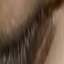

Right Eye:


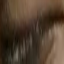

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Left Eye: 0.2651
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0012457371), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 8...
Left Eye: (flipped)


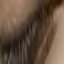

Right Eye:


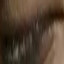

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Left Eye: 0.2651
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0010347366), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 9...
Left Eye: (flipped)


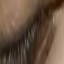

Right Eye:


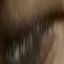

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Left Eye: 0.2651
Right Eye: 0.2648
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0010764599), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 10...
Left Eye: (flipped)


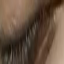

Right Eye:


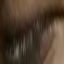

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Left Eye: 0.2651
Right Eye: 0.2649
Average: 0.2650
Memberships: {'drowsy': np.float32(0.0006580353), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy
Overall Average for 10 frames: 0.2649
Memberships: {'drowsy': np.float32(0.0011706352), 'not_drowsy': 0}
→ Final Fuzzy Prediction: drowsy


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_eye(eye_input):
    img = cv2.cvtColor(eye_input, cv2.COLOR_BGR2GRAY)         # Convert to grayscale
    img = img / 255.0                                   # Normalize
    img = np.expand_dims(img, axis=0)                   # Add batch dimension
    img = np.expand_dims(img, axis=-1)                  # Add channel dimension
    return img


def process_plot_img(left_input, right_input):
    # Preprocess both eyes
    left_eye_processed = preprocess_eye(left_input)
    right_eye_processed = preprocess_eye(right_input)

    # Check shapes
    print("Left eye shape:", left_eye_processed.shape)   # (1, 64, 64, 1)
    print("Right eye shape:", right_eye_processed.shape) # (1, 64, 64, 1)

    return left_eye_processed, right_eye_processed

def fuzzify(pred):
    # Drowsy: High membership for lower values
    drowsy = max(0, min(1, (0.265 - pred) / 0.05))  # Z-shape (approx)

    # Not Drowsy: High membership for higher values
    not_drowsy = max(0, min(1, (pred - 0.2651) / 0.05))  # S-shape (approx)

    return {
        'drowsy': drowsy,
        'not_drowsy': not_drowsy
    }


def predict_eye_state(model, eye_image, lower=0.2650):
    if eye_image is None or eye_image.size == 0:
      print("Error: Invalid eye image. Skipping prediction.")
      return np.nan, "invalid_image"  # Return NaN and a label to indicate invalid image

    img_array = eye_image
    # Predict
    prediction = model.predict(img_array)[0][0]

    # Interpret result
    if prediction <= lower:
        label = 'drowsy'
    else:
        label = 'not_drowsy'

    return prediction, label

def prediction_per_frame(model, left_input, right_input):
    left_pred, left_label = predict_eye_state(model, left_input)
    right_pred, right_label = predict_eye_state(model, right_input)

    avg_pred = (left_pred + right_pred) / 2

    # Fuzzify the average prediction
    memberships = fuzzify(avg_pred)

    # Decide final label based on max membership
    final_label = max(memberships, key=memberships.get)

    # Output
    print(f"Left Eye: {left_pred:.4f}")
    print(f"Right Eye: {right_pred:.4f}")
    print(f"Average: {avg_pred:.4f}")
    print("Memberships:", memberships)
    print(f"→ Fuzzy Prediction: {final_label}")


    return avg_pred, final_label


# Initialize Mediapipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

# Load video or webcam
video_path = "/content/video4.mp4"  # <-- Replace with 0 for webcam or use path
cap = cv2.VideoCapture(video_path)

frame_count = 0
max_frames = 10  # Set the number of frames you want to process
overall_avg_pred = 0

while cap.isOpened() and frame_count < max_frames:
    success, image = cap.read()
    if not success:
        break

    frame_count += 1
    print(f"\nProcessing Frame {frame_count}...")

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            left_eye_indices = [362, 385, 387, 263, 373, 380]
            right_eye_indices = [33, 160, 158, 133, 153, 144]

            def get_eye_crop(indices):
                points = [(int(face_landmarks.landmark[i].x * w), int(face_landmarks.landmark[i].y * h)) for i in indices]
                x_coords, y_coords = zip(*points)
                x_min, x_max = max(min(x_coords)-5, 0), min(max(x_coords)+5, w)
                y_min, y_max = max(min(y_coords)-5, 0), min(max(y_coords)+5, h)
                return image[y_min:y_max, x_min:x_max]

            left_eye_crop = get_eye_crop(left_eye_indices)
            right_eye_crop = get_eye_crop(right_eye_indices)

            left_eye_resized = cv2.resize(left_eye_crop, (64, 64))
            right_eye_resized = cv2.resize(right_eye_crop, (64, 64))

            left_eye_resized = cv2.flip(left_eye_resized, 1)

            # Show results
            print("Left Eye: (flipped)")
            cv2_imshow(left_eye_resized)
            print("Right Eye:")
            cv2_imshow(right_eye_resized)

            left_eye_processed, right_eye_processed = process_plot_img(left_eye_resized, right_eye_resized)

            avg_pred, final_label = prediction_per_frame(model, left_eye_processed, right_eye_processed)

            overall_avg_pred += avg_pred

            if frame_count == 10:
              overall_avg_pred /= 10

                  # Fuzzify the average prediction
              memberships = fuzzify(overall_avg_pred)

              # Decide final label based on max membership
              final_label = max(memberships, key=memberships.get)

              print(f"Overall Average for 10 frames: {overall_avg_pred:.4f}")
              print("Memberships:", memberships)
              print(f"→ Final Fuzzy Prediction: {final_label}")
    else:
        print("No face landmarks detected.")

cap.release()



Processing Frame 1...
Left Eye: (flipped)


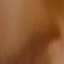

Right Eye:


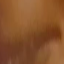

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0016438961), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 2...
Left Eye: (flipped)


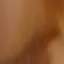

Right Eye:


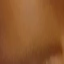

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Left Eye: 0.2650
Right Eye: 0.2650
Average: 0.2650
Memberships: {'drowsy': np.float32(0.00053942204), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 3...
Left Eye: (flipped)


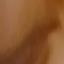

Right Eye:


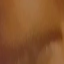

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0020843744), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 4...
Left Eye: (flipped)


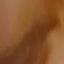

Right Eye:


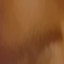

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0021982193), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 5...
Left Eye: (flipped)


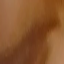

Right Eye:


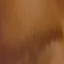

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0023961067), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 6...
Left Eye: (flipped)


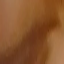

Right Eye:


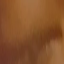

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0024056435), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 7...
Left Eye: (flipped)


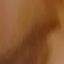

Right Eye:


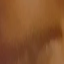

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.002349019), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 8...
Left Eye: (flipped)


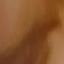

Right Eye:


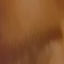

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0022912025), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 9...
Left Eye: (flipped)


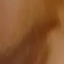

Right Eye:


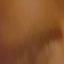

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0022530556), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy

Processing Frame 10...
Left Eye: (flipped)


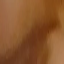

Right Eye:


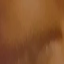

Left eye shape: (1, 64, 64, 1)
Right eye shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Left Eye: 0.2649
Right Eye: 0.2649
Average: 0.2649
Memberships: {'drowsy': np.float32(0.0022125244), 'not_drowsy': 0}
→ Fuzzy Prediction: drowsy
Overall Average for 10 frames: 0.2649
Memberships: {'drowsy': np.float32(0.0020372868), 'not_drowsy': 0}
→ Final Fuzzy Prediction: drowsy


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_eye(eye_input):
    img = cv2.cvtColor(eye_input, cv2.COLOR_BGR2GRAY)         # Convert to grayscale
    img = img / 255.0                                   # Normalize
    img = np.expand_dims(img, axis=0)                   # Add batch dimension
    img = np.expand_dims(img, axis=-1)                  # Add channel dimension
    return img


def process_plot_img(left_input, right_input):
    # Preprocess both eyes
    left_eye_processed = preprocess_eye(left_input)
    right_eye_processed = preprocess_eye(right_input)

    # Check shapes
    print("Left eye shape:", left_eye_processed.shape)   # (1, 64, 64, 1)
    print("Right eye shape:", right_eye_processed.shape) # (1, 64, 64, 1)

    return left_eye_processed, right_eye_processed

def fuzzify(pred):
    # Drowsy: High membership for lower values
    drowsy = max(0, min(1, (0.265 - pred) / 0.05))  # Z-shape (approx)

    # Not Drowsy: High membership for higher values
    not_drowsy = max(0, min(1, (pred - 0.2651) / 0.05))  # S-shape (approx)

    return {
        'drowsy': drowsy,
        'not_drowsy': not_drowsy
    }


def predict_eye_state(model, eye_image, lower=0.2650):
    if eye_image is None or eye_image.size == 0:
      print("Error: Invalid eye image. Skipping prediction.")
      return np.nan, "invalid_image"  # Return NaN and a label to indicate invalid image

    img_array = eye_image
    # Predict
    prediction = model.predict(img_array)[0][0]

    # Interpret result
    if prediction <= lower:
        label = 'drowsy'
    else:
        label = 'not_drowsy'

    return prediction, label

def prediction_per_frame(model, left_input, right_input):
    left_pred, left_label = predict_eye_state(model, left_input)
    right_pred, right_label = predict_eye_state(model, right_input)

    avg_pred = (left_pred + right_pred) / 2

    # Fuzzify the average prediction
    memberships = fuzzify(avg_pred)

    # Decide final label based on max membership
    final_label = max(memberships, key=memberships.get)

    # Output
    print(f"Left Eye: {left_pred:.4f}")
    print(f"Right Eye: {right_pred:.4f}")
    print(f"Average: {avg_pred:.4f}")
    print("Memberships:", memberships)
    print(f"→ Fuzzy Prediction: {final_label}")


    return avg_pred, final_label


# Initialize Mediapipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

# Load video or webcam
video_path = "/content/latest_video(3).webm"
cap = cv2.VideoCapture(video_path)

frame_count = 0
max_frames = 10  # Set the number of frames you want to process
overall_avg_pred = 0

while cap.isOpened() and frame_count < max_frames:
    success, image = cap.read()
    if not success:
        break

    frame_count += 1
    print(f"\nProcessing Frame {frame_count}...")

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            left_eye_indices = [362, 385, 387, 263, 373, 380]
            right_eye_indices = [33, 160, 158, 133, 153, 144]

            def get_eye_crop(indices):
                points = [(int(face_landmarks.landmark[i].x * w), int(face_landmarks.landmark[i].y * h)) for i in indices]
                x_coords, y_coords = zip(*points)
                x_min, x_max = max(min(x_coords)-5, 0), min(max(x_coords)+5, w)
                y_min, y_max = max(min(y_coords)-5, 0), min(max(y_coords)+5, h)
                return image[y_min:y_max, x_min:x_max]

            left_eye_crop = get_eye_crop(left_eye_indices)
            right_eye_crop = get_eye_crop(right_eye_indices)

            left_eye_resized = cv2.resize(left_eye_crop, (64, 64))
            right_eye_resized = cv2.resize(right_eye_crop, (64, 64))

            left_eye_resized = cv2.flip(left_eye_resized, 1)

            # Show results
            print("Left Eye: (flipped)")
            cv2_imshow(left_eye_resized)
            print("Right Eye:")
            cv2_imshow(right_eye_resized)

            left_eye_processed, right_eye_processed = process_plot_img(left_eye_resized, right_eye_resized)

            avg_pred, final_label = prediction_per_frame(model, left_eye_processed, right_eye_processed)

            overall_avg_pred += avg_pred

            if frame_count == 10:
              overall_avg_pred /= 10

                  # Fuzzify the average prediction
              memberships = fuzzify(overall_avg_pred)

              # Decide final label based on max membership
              final_label = max(memberships, key=memberships.get)

              print(f"Overall Average for 10 frames: {overall_avg_pred:.4f}")
              print("Memberships:", memberships)
              print(f"→ Final Fuzzy Prediction: {final_label}")
    else:
        print("No face landmarks detected.")

cap.release()
